In [522]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import sklearn
import scipy.stats as stats
import sklearn.neighbors as neighbors
import scipy.interpolate as interpolate
from lab7.xgboost_example import X_train
from sklearn.metrics import mean_squared_error

In [509]:
def g_of_x(x):
    return 4.62*(np.exp(-x)-4*np.exp(-2*x)+3*np.exp(-3*x))

def MSE(y, y_hat):
    return mean_squared_error(y, y_hat)
def generate_data(n=1000):
    x=np.random.uniform(0, 4, n)
    eps=np.random.normal(0, 0.1, n)
    y=g_of_x(x)+eps
    return x,y

In [510]:
class Regressor(object):
    def __init__(self):
        pass

    def fit(self, x, y):
        self.x = x.reshape(-1, 1)
        self.y = y.reshape(-1, 1)
        return self

    def predict(self, x):
        raise NotImplementedError("Subclasses should implement this!")

In [511]:
class NadarayaWatsonKernelRegressor(Regressor):
    def __init__(self,K,K_args):
        super().__init__()
        self.K = K(**K_args)
    
    def predict(self, x):
        N=x.shape[0]
        y_pred = np.zeros(N)
        for i in range(N):
            weights= self.K.eval(x[i],self.x)
            Y= np.dot(self.y.T,weights) / np.sum(weights)
            y_pred[i] = Y[0][0]
        return y_pred

In [512]:
class GaussianKernel:
    def __init__(self, bandwidth):
        self.bandwidth = bandwidth
    def eval(self, x, x0):
        return np.exp(-np.square(x-x0) / (2 * np.square(self.bandwidth))) / (np.sqrt(2 * np.pi) * self.bandwidth)
    
class UniformKernel:
    def __init__(self, bandwidth):
        self.bandwidth = bandwidth
    def eval(self, x, x0):
        return np.where(np.abs(x - x0) < self.bandwidth/2, 1, 0)

In [513]:
class SmoothingSpline(Regressor):
    def __init__(self, lam=0.1):
        super().__init__()
        self.lam=lam
    def fit(self, x, y):
        idx=np.argsort(x.flatten())
        self.x = x[idx]
        self.y = y[idx]
        self.spline = interpolate.make_smoothing_spline(self.x.flatten(), self.y.flatten(), lam=self.lam)
        return self
    def predict(self, x):
        return self.spline(x)

In [518]:
def plot_comparison(x_test,y_hat,y_hat_ss):
    x_test=x_test.reshape(-1,)
    idx=np.argsort(x_test)
    x_lin=np.linspace(0, 4, 1000)
    y_lin=g_of_x(x_lin)
    plt.figure(figsize=(16, 9))
    plt.title("Nadaraya-Watson Kernel Regression vs Smoothing Spline plot")
    plt.plot(x_test[idx],y_hat[idx], label="Nadaraya-Watson")
    plt.plot(x_lin,y_lin, label="True")
    plt.plot(x_test[idx],y_hat_ss[idx], label="Smoothing Spline")
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(16, 9))
    plt.title("Nadaraya-Watson Kernel Regression vs Smoothing Spline scatter")
    plt.scatter(x_test,y_hat, label="Nadaraya-Watson")
    plt.scatter(x_lin,y_lin, label="True")
    
    plt.scatter(x_test,y_hat_ss, label="Smoothing Spline")
    plt.legend()
    plt.show()


In [571]:
K_args={"bandwidth": 0.1}
K=GaussianKernel
x,y=generate_data(100)
x=x.reshape(-1, 1)
x_test=np.linspace(0, 4, 500).reshape(-1, 1)
y_hat=NadarayaWatsonKernelRegressor(K, K_args).fit(x, y).predict(x_test)
y_hat_ss=SmoothingSpline(lam=0.1).fit(x,y).predict(x_test)
y_true=g_of_x(x_test)
MSE(y_true, y_hat), MSE(y_true, y_hat_ss)

(0.003585602270512751, 0.012145107982371455)

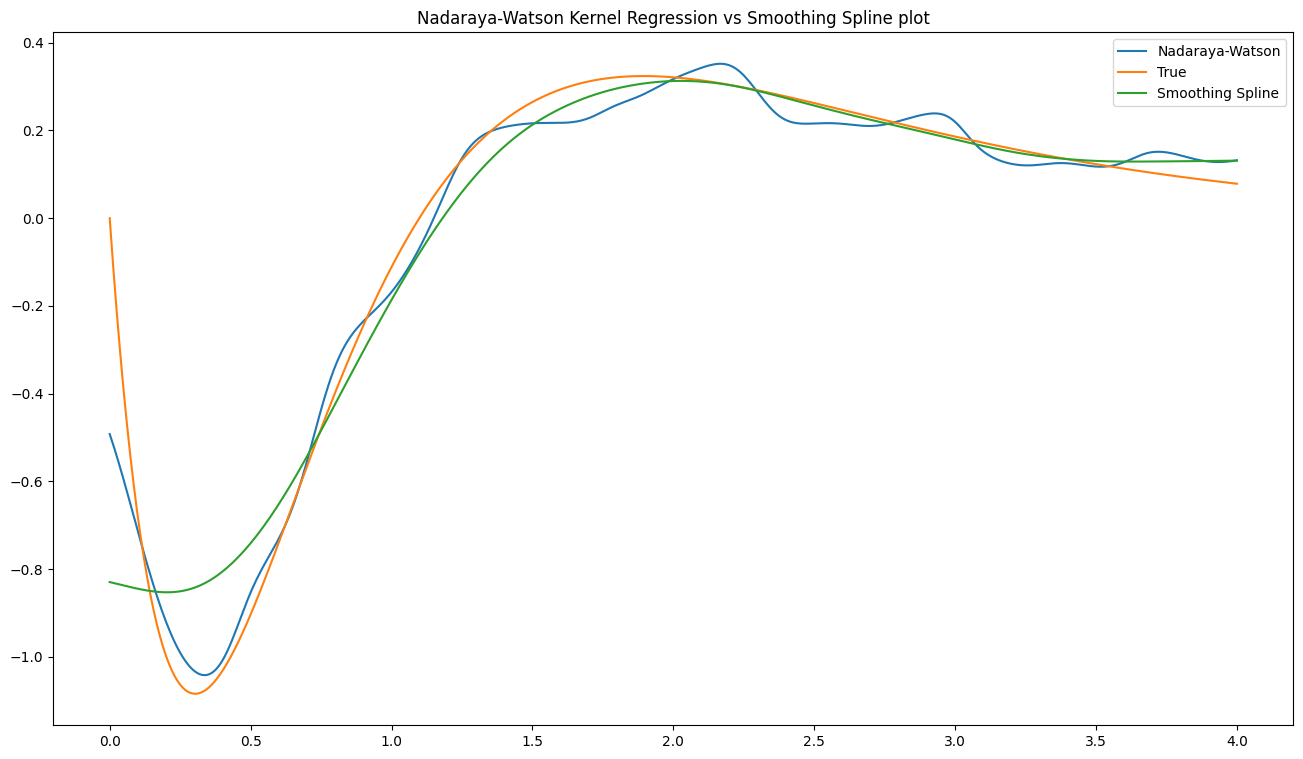

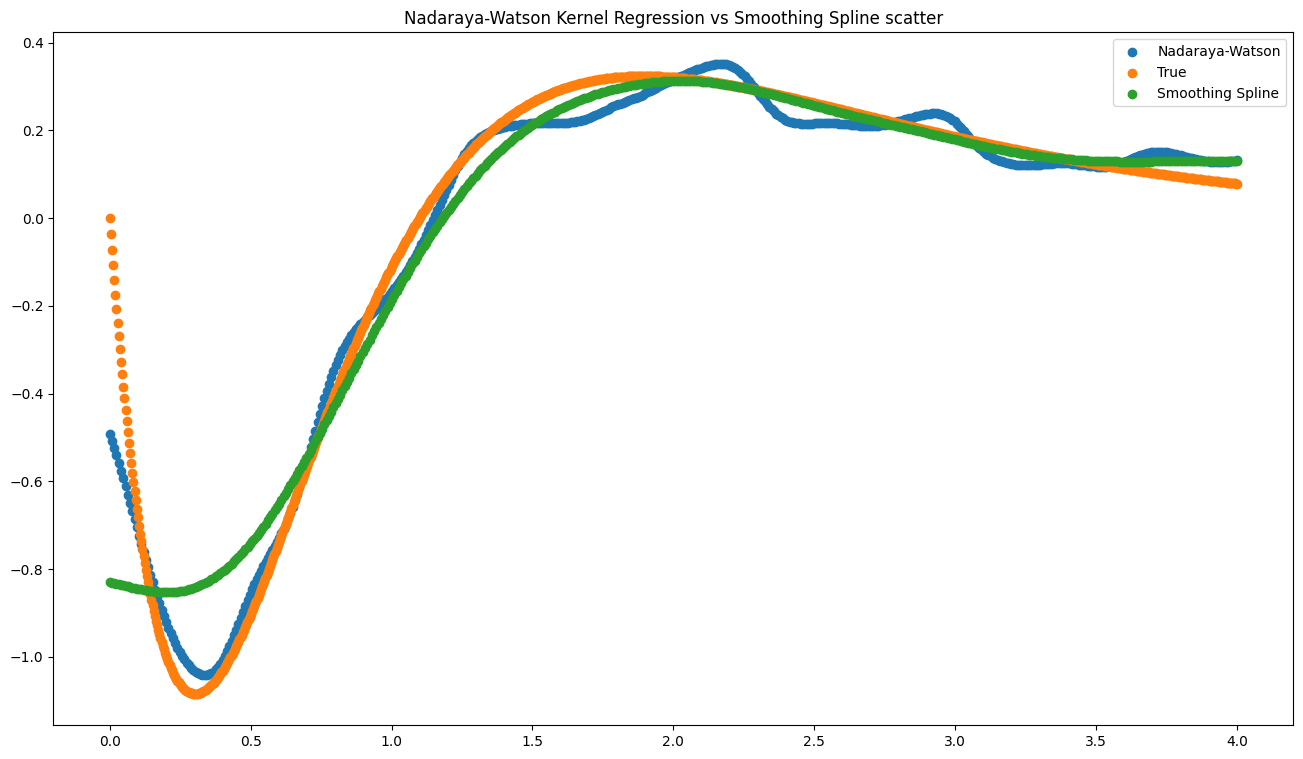

In [572]:
plot_comparison(x_test,y_hat,y_hat_ss)

In [578]:
def compare_MSE():
    N=np.linspace(10,1000,100).astype(int)
    K=GaussianKernel
    K_args={"bandwidth": 0.5}
    mse_nw=[]
    mse_ss=[]
    x_test=np.linspace(0, 4, 500).reshape(-1, 1)
    y_test=g_of_x(x_test)
    
    for n in N: 
        x,y=generate_data(n)
        x=x.reshape(-1,1)
        y_hat=NadarayaWatsonKernelRegressor(K, K_args).fit(x, y).predict(x_test)
        y_hat_ss=SmoothingSpline(lam=0.1).fit(x, y).predict(x_test)
        mse_nw.append(MSE(y_test, y_hat))
        mse_ss.append(MSE(y_test, y_hat_ss))
    
    plt.figure(figsize=(12, 6))
    plt.plot(N, mse_nw, label="Nadaraya-Watson")
    plt.plot(N, mse_ss, label="Smoothing Spline")
    plt.xlabel("Number of samples")
    plt.legend()
    plt.ylabel("MSE")

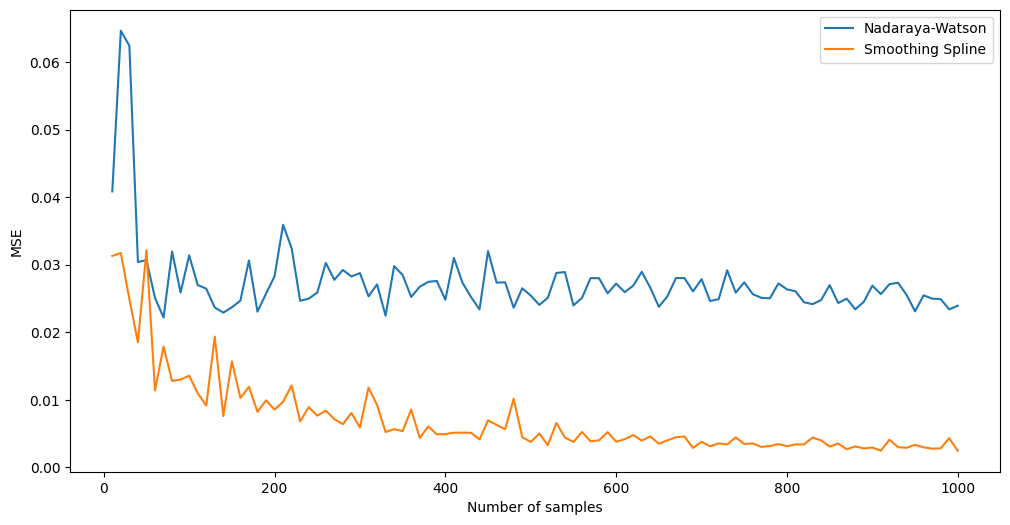

In [579]:
compare_MSE()